In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'serif' : 'Computer Modern Roman',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.figsize'] = [2*3.54, 3.54]

from systems import DoubleIntegrator, DoubleIntegratorWithPerturbations

from nnpolicy import NNPolicy
import torch

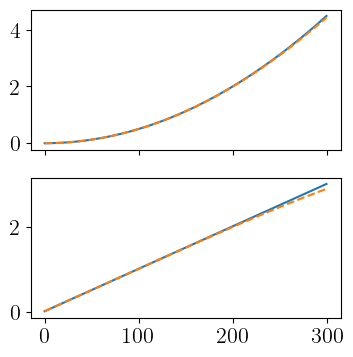

In [2]:
dt = 0.01
N = 300

# System
system = DoubleIntegrator(dt)
system_perturb = DoubleIntegratorWithPerturbations(dt)

system.state = np.zeros(2)
system_perturb.state = np.zeros(2)
state_list = []
state_perturb_list = []

for i in range(N):
    action = 1.0
    result = system.step(action)
    result_perturb = system_perturb.step(action)
    state_list.append(system.state)
    state_perturb_list.append(system_perturb.state)
    
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
state_list = np.array(state_list)
state_perturb_list = np.array(state_perturb_list)
ax[0].plot(state_list[:, 0], '-', label='x')
ax[0].plot(state_perturb_list[:, 0], '--', label='x with perturbations')
ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
ax[1].plot(state_perturb_list[:, 1], '--', label='\dot{x} with perturbations')


In [3]:
# Multiple traj regulation:
frequency = np.random.uniform(0.01, 0.05)
def multiple_traj_reg(sys, sys_name, policy):
    nb_traj = 1
    fig, ax = plt.subplots(3, 1, figsize=(3, 3), sharex=True)
    for i in range(nb_traj):
        sys.reset()
        state_list = []
        def get_N_pt_traj(N, frequency):
            des_traj_pos = lambda t: np.cos(t*frequency) + np.sin(3*t*frequency) + np.tanh(t*frequency)
            pos_des = [des_traj_pos(i) for i in range(N)]
            des_traj_vel = np.zeros(N)

            for i in range(N - 1):
                des_traj_vel[i] = (pos_des[i+1] - pos_des[i])/dt
            des_traj_vel[-1] = des_traj_vel[-2]
            return pos_des, des_traj_vel

        des_traj_pos, des_traj_vel = get_N_pt_traj(N, frequency)

        sys.state = np.array([des_traj_pos[0], des_traj_vel[0]])
        for i in range(N):
            state_des = np.array([ des_traj_pos[i], des_traj_vel[i] ])
            result = policy(sys.state, state_des)
            if len(result) == 1:
                action = result
            else:
                action = result[0]
            if type(action) is not np.float64:
                action = action.detach().numpy()
            result = sys.step(action.squeeze())
            state_list.append(sys.state)
            
        state_list = np.array(state_list)
        ax[0].plot(state_list[:, 0], '-', label='x')
        ax[0].plot(des_traj_pos, '--', label='x_d')
        ax[0].set_ylabel('Pos.')
        ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
        ax[1].plot(des_traj_vel, '--', label='\dot{x}_d')
        ax[0].set_title(sys_name, fontsize='xx-small')
        ax[1].set_ylabel('Vel.')
        
        # plot error
        ax[2].plot(np.abs(state_list[:, 0] - des_traj_pos), '-', label='x error')
        



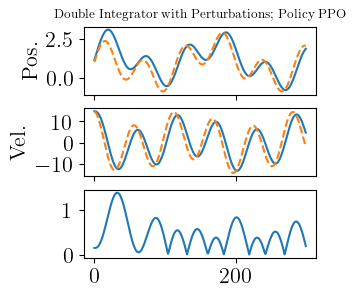

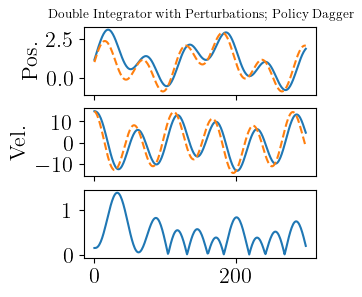

In [5]:

## PPO Policy

directory = 'PPO_preTrained/DoubleIntegrator/'
path_NN = directory + '/PPO_DoubleIntegrator_0_0.pth'
from PPO import ActorCritic
import matplotlib.pyplot as plt
import torch
state_dim = 2
action_dim = 1
has_continuous_action_space = True
action_std_init = 0.6
policy_PPO = ActorCritic(state_dim, action_dim, action_std_init)

# load weights
policy_PPO.load_state_dict(torch.load(path_NN))

def policy_PPO_wrapper(x, x_des):
    x = torch.tensor(x, dtype=torch.float32)
    x_des = torch.tensor(x_des, dtype=torch.float32)
    return policy_PPO.act(x, x_des)


# Imit learning Policy

net_arch = [(4, 24), (24, 48), (48, 24), (24, 1)] # NN policy
policy = NNPolicy(net_arch)
policy.load_state_dict(torch.load('models/model_weights.pth'))
def policy_IL_wrapper(x, x_des):
    NN_input = torch.tensor(np.concatenate((x, x_des)), dtype=torch.float32)
    return policy.predict(NN_input)


multiple_traj_reg(system, sys_name = 'Double Integrator with Perturbations; Policy PPO', policy=policy_PPO_wrapper)
multiple_traj_reg(system, sys_name = 'Double Integrator with Perturbations; Policy Dagger', policy=policy_IL_wrapper)
